In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import numpy as np
import pandas as pd
import html
import re
from fastai.text import *

# Data Preparation

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

LANG = 'id'
PATH_ROOT = Path(f'lmdata/{LANG}/')
PATH_EXTRACT = Path(f'{PATH_ROOT}/extract/')
PATH_TMP = Path(f'{PATH_ROOT}/tmp/')

In [4]:
LANG_FILENAMES = [str(f) for f in PATH_EXTRACT.rglob("*/wiki_*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

517


['lmdata/id/extract/AA/wiki_00',
 'lmdata/id/extract/AA/wiki_01',
 'lmdata/id/extract/AA/wiki_02',
 'lmdata/id/extract/AA/wiki_03',
 'lmdata/id/extract/AA/wiki_04']

In [5]:
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

100%|██████████| 517/517 [00:04<00:00, 108.40it/s]


In [6]:
LANG_TEXT.head()

,id,text,title,url
0,1,Asam deoksiribonukleat\n\nAsam deoksiribonukle...,Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Anwar Sadat\n\nJenderal Besar Mohammed Anwar A...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Azhar Mansor\n\nDatuk Azhar Mansor adalah oran...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi\n\nArkeologi atau ilmu kepurbakalaan...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi\n\nAntropologi adalah ilmu tentang...,Antropologi,https://id.wikipedia.org/wiki?curid=6


In [7]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [8]:
LANG_TEXT.head()

,id,text,title,url
0,1,"Asam deoksiribonukleat, lebih dikenal dengan s...",Asam deoksiribonukleat,https://id.wikipedia.org/wiki?curid=1
1,3,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,Anwar Sadat,https://id.wikipedia.org/wiki?curid=3
2,4,Datuk Azhar Mansor adalah orang Malaysia perta...,Azhar Mansor,https://id.wikipedia.org/wiki?curid=4
3,5,Arkeologi atau ilmu kepurbakalaan berasal dari...,Arkeologi,https://id.wikipedia.org/wiki?curid=5
4,6,Antropologi adalah ilmu tentang manusia. Antro...,Antropologi,https://id.wikipedia.org/wiki?curid=6


Sorting the articles by length and keeping the first million (this is actually not necessary for indonesian wiki since it has less than 450k articles in 2018).

In [9]:
LANG_TEXT = LANG_TEXT.assign(length = 0)
LANG_TEXT.columns = ['id', 'text', 'title', 'url', 'length']
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[['labels', 'text', 'length']])

In [10]:
LANG_TEXT.head()

,labels,text,length
0,0,"Asam deoksiribonukleat, lebih dikenal dengan s...",0
1,0,Jenderal Besar Mohammed Anwar Al Sadat (; ) ad...,0
2,0,Datuk Azhar Mansor adalah orang Malaysia perta...,0
3,0,Arkeologi atau ilmu kepurbakalaan berasal dari...,0
4,0,Antropologi adalah ilmu tentang manusia. Antro...,0


In [11]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()
LANG_TEXT = LANG_TEXT.sort_values(by=['length'], ascending=False)

In [12]:
LANG_TEXT.head()

,labels,text,length
188441,0,Technische Hoogeschool te Bandoeng biasa disin...,159917
114692,0,Kemilau Cinta Kamila atau biasa disingkat KCK ...,141607
1370,0,"Republik Chili (), kadang-kadang dieja sebagai...",133775
4340,0,Josef Vissarionovich Stalin () adalah pemimpin...,129387
5079,0,Perang Dunia I (PDI) adalah sebuah perang glob...,127190


In [13]:
len(LANG_TEXT)

439609

In [14]:
LANG_TEXT.to_csv(f"{PATH_ROOT}/wiki_{LANG}_corpus.csv", header=False, index=False)

In [19]:
LANG_TEXT = pd.read_csv(f"{PATH_ROOT}/wiki_{LANG}_corpus.csv")

In [20]:
len(LANG_TEXT)

439608

In [21]:
LANG_TEXT.columns = ['labels', 'text', 'length']
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 10]
# LANG_TEXT = LANG_TEXT.drop(['length'], axis=1)

In [23]:
LANG_TEXT.head()

,labels,text,length
0,0,Kemilau Cinta Kamila atau biasa disingkat KCK ...,141607
1,0,"Republik Chili (), kadang-kadang dieja sebagai...",133775
2,0,Josef Vissarionovich Stalin () adalah pemimpin...,129387
3,0,Perang Dunia I (PDI) adalah sebuah perang glob...,127190
4,0,Sejarah dunia adalah sejarah umat manusia di s...,127135


In [24]:
len(LANG_TEXT)

433390

## Some statistics of Indonesia Wikipedia

### Number of documents

In [25]:
print(LANG_TEXT['text'][:5])
LANG_TEXT.shape

0    Kemilau Cinta Kamila atau biasa disingkat KCK ...
1    Republik Chili (), kadang-kadang dieja sebagai...
2    Josef Vissarionovich Stalin () adalah pemimpin...
3    Perang Dunia I (PDI) adalah sebuah perang glob...
4    Sejarah dunia adalah sejarah umat manusia di s...
Name: text, dtype: object


(433390, 3)

### Number of words in all the documents

In [26]:
def x_split(x):
    l = 0
    try:
        l = len(x.split(" "))
    except AttributeError:
        print(x)
    return l

LANG_TEXT['text'].apply(lambda x: x_split(x)).sum()    
#LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

63412376

### Number of unique tokens across documents

In [27]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

3600171

## Clear plain text

In [28]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

## Tokenize

In [29]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): 
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Create validation set

In [30]:
#LANG_TEXT = pd.read_csv(f"{PATH_ROOT}/wiki_{LANG}_corpus.csv")
#LANG_TEXT.columns = ['labels', 'text']

In [31]:
print(LANG_TEXT.head())
LANG_TEXT.shape

   labels                                               text  length
0       0  Kemilau Cinta Kamila atau biasa disingkat KCK ...  141607
1       0  Republik Chili (), kadang-kadang dieja sebagai...  133775
2       0  Josef Vissarionovich Stalin () adalah pemimpin...  129387
3       0  Perang Dunia I (PDI) adalah sebuah perang glob...  127190
4       0  Sejarah dunia adalah sejarah umat manusia di s...  127135


(433390, 3)

In [32]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [33]:
len(trn_texts), len(val_texts)

(390051, 43339)

In [34]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text', 'length']
df_val.columns = ['labels', 'text', 'length']

df_trn.to_csv(f"{PATH_ROOT}/wiki_{LANG}_train.csv", header=False, index=False)
df_val.to_csv(f"{PATH_ROOT}/wiki_{LANG}_test.csv", header=False, index=False) # saving the data in our new format to disk

In [35]:
chunksize = 10000
df_trn = pd.read_csv(f"{PATH_ROOT}/wiki_{LANG}_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"{PATH_ROOT}/wiki_{LANG}_test.csv", header=None, chunksize=chunksize)

In [36]:
wiki_tok_trn, wiki_trn_labels = get_all(df_trn, 1)
wiki_tok_val, wiki_val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4


In [37]:
# create a tmp directory to store the upcoming numpy arrays
(PATH_TMP).mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(PATH_TMP/'wiki_tok_trn.npy', wiki_tok_trn)
np.save(PATH_TMP/'wiki_tok_val.npy', wiki_tok_val)

In [6]:
wiki_tok_trn = np.load(PATH_TMP/'wiki_tok_trn.npy')
wiki_tok_val = np.load(PATH_TMP/'wiki_tok_val.npy')

In [39]:
print("Trn:", wiki_tok_trn[:2], "\n")

Trn: [['\n', 'xbos', 'xfld', '1', 'i', 'made', 'putra', 'budi', 'sartika', '(;', 'nama', 'asli', 'dari', 'bobby', 'kool', ')', 'adalah', 'personel', 'dari', 'grup', 'musik', 'asal', 'bali', ',', 'indonesia', ',', 'superman', 'is', 'dead', '.', 'di', 'grup', 'superman', 'is', 'dead', ',', 'bobby', 'memainkan', 'instrumen', 'gitar', 'dan', 'sekaligus', 'sebagai', 'vokalis.awal', 'karier', '.', '\n', 'nama', 'panggilannya', 'ketika', 'masa', 'kanak', '-', 'kanak', 'adalah', 'bobby', 'bikul', '(', 'bikul', 'berarti', 'tikus', 'dalam', 'bahasa', 'bali', ')', '.', 'ketika', 'kariernya', 'dalam', 'musik', 'dimulai', 'ia', 'mengganti', 'namanya', 'menjadi', 'bobby', 'kool', '.', 'masa', 'kanak', '-', 'kanaknya', 'dihabiskan', 'di', 'denpasar', '.', 'ia', 'menyelesaikan', 'kuliahnya', 'di', 'sastra', 'inggris', ',', 'fakultas', 'sastra', 'universitas', 'warmadewa', 'denpasar', '.', 'pada', 'masa', 'perkenalannya', 'dengan', 'musik', 'ia', 'lebih', 'tertarik', 'memainkan', 'alat', 'musik', 'drum

In [46]:
# Get the Counter object from all the splitted files.
# Identify the most common tokens
freq = Counter(p for o in wiki_tok_trn for p in o) 
freqs = pd.DataFrame.from_dict(freq, orient="index")
freqs.sort_values(0, ascending=False).head(25)

,0
",",3677884
.,2876800
dan,1680702
yang,1675407
di,1255488
"""",1226023
\n,887765
1,835020
-,820385
dari,816201


In [47]:
# Sanity check
len([p for o in wiki_tok_trn for p in o])

73009286

In [49]:
cnt = []
for i in range(49):
    row_cnt = freqs[freqs[0]>=i+1].shape[0]
    cnt.append(row_cnt)

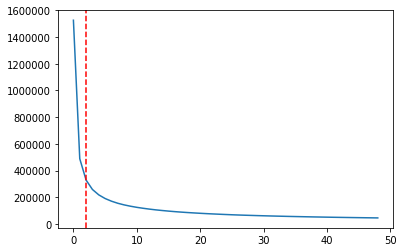

In [50]:
plt.plot(cnt)
plt.axvline(x=2, color="red", linestyle="--")

## Numericalize the text

In [51]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

wiki_itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
wiki_itos.insert(0, '_pad_') # 
wiki_itos.insert(0, '_unk_') # wiki_itos is the list of all the strings in the vocab

In [52]:
# creating a index-key dictionary for our vocabulary
wiki_stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(wiki_itos)})
len(wiki_itos)

60002

In [53]:
# creating a index representation for our train and validation dataset
wiki_trn_lm = np.array([[wiki_stoi[o] for o in p] for p in wiki_tok_trn])
wiki_val_lm = np.array([[wiki_stoi[o] for o in p] for p in wiki_tok_val])

In [54]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(PATH_TMP/'wiki_trn_ids.npy', wiki_trn_lm)
np.save(PATH_TMP/'wiki_val_ids.npy', wiki_val_lm)
pickle.dump(wiki_itos, open(f'{PATH_ROOT}/wiki_{LANG}_itos.pkl', 'wb'))

In [4]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(PATH_TMP/'wiki_trn_ids.npy')
val_lm = np.load(PATH_TMP/'wiki_val_ids.npy')
wiki_itos = pickle.load(open(f'{PATH_ROOT}/wiki_{LANG}_itos.pkl', 'rb'))

In [5]:
# checking vocabulary size
vs=len(wiki_itos)
word_count = 0
for i in trn_lm:
    word_count += len(trn_lm[i])

In [6]:
print(f'vocabulary size: {vs}, #articles: {len(trn_lm)}, #words: {word_count}')

vocabulary size: 60002, #articles: 390051, #words: 73009286


# Model Setup

# Language Model

In [7]:
em_sz,nh,nl = 400,1150,3

wd=1e-7
bptt=70
#bs=52
bs=40
#opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.3

In [8]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*weight_factor

In [9]:
%time

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH_ROOT, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [10]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [11]:
# AWD-LSTM network
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)>

In [66]:
learner.lr_find2(num_it=1000)

  4%|▍         | 1000/26073 [04:19<1:48:22,  3.86it/s, loss=7.57]

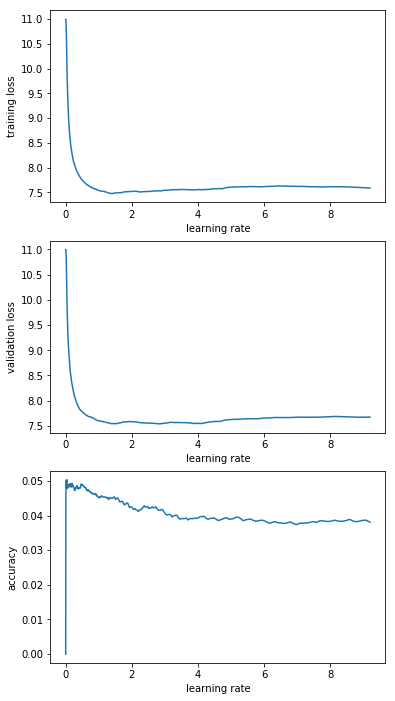

In [67]:
learner.sched.plot()

In [12]:
# Set learning rate
lr = 8

In [13]:
# we can load the trained model and re-train again
learner.load(f'wiki_{LANG}_1cycle_best')

In [14]:
learner.fit(lr, 1, wds=wd, cycle_len=10, use_clr=(10,33,0.95,0.85), best_save_name=f'wiki_{LANG}_1cycle_best')

epoch      trn_loss   val_loss   accuracy                         
    0      3.540105   3.552252   0.364585  
    1      3.584985   3.543127   0.366068                         
    2      3.441354   3.53446    0.367475                         
    3      3.50821    3.52739    0.368057                         
    4      3.425858   3.523544   0.367965                         
    5      3.477638   3.5003     0.371117                         
 35%|███▌      | 9240/26073 [29:25<53:36,  5.23it/s, loss=3.33]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 68%|██████▊   | 17749/26073 [56:32<26:31,  5.23it/s, loss=3.33]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation:  16%|█▌        | 447/2873 [00:32<02:57, 13.67it/s]    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    7      3.336928   3.469808   0.37458                          
    8      3.321467   3.440167   0.37694                          
    9      3.403565   3.392843   0.382901                         



[array([3.39284]), 0.3829011047110506]

In [15]:
learner.save(f'wiki_{LANG}_lm')
learner.save_encoder(f'wiki_{LANG}_lm_enc')

In [16]:
learner.load(f'wiki_{LANG}_lm')
learner.load_encoder(f'wiki_{LANG}_lm_enc')

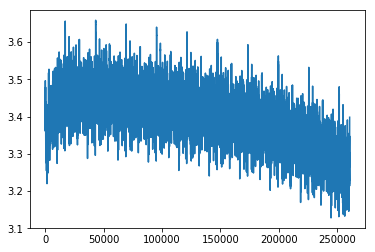

In [17]:
learner.sched.plot_loss()

In [18]:
# The perplexity of this language model after 15 epochs is 31.03
np.exp(3.392)

29.725343546388515

# Train again the pre-trained model

In [12]:
learner.load(f'wiki_{LANG}_lm')
learner.load_encoder(f'wiki_{LANG}_lm_enc')

## Generate sentence using the language model

In [13]:
LANG = 'id'
LM_PATH = Path(f'lmdata/{LANG}/')
LM_PATH_MODEL = f'{LM_PATH}/models/wiki_{LANG}_lm.h5'
LM_PATH_ITOS = f'{LM_PATH}/wiki_{LANG}_itos.pkl'
#LM_PATH_MODEL = f'{LM_PATH}/models/lm_indonesia_final.h5'
#LM_PATH_ITOS = f'/mnt/mldata/data/LM/imdb_data/id/lm/tmp/itos.pkl'

In [14]:
wiki_itos = pickle.load(open(LM_PATH_ITOS, 'rb'))
wiki_stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(wiki_itos)})
vs = len(wiki_itos)
print("vs:", vs)

vs: 60002


In [15]:
em_sz,nh,nl = 400,1150,3

seq_rnn = get_language_model(vs, em_sz, nh, nl, 1)
lm = LanguageModel(to_gpu(seq_rnn))
load_model(seq_rnn, LM_PATH_MODEL)

In [16]:
seq_rnn.eval()
seq_rnn[0].bs = 1

In [19]:
def generate_text(ss,topk):
    s = ss.strip().split(" ")
    t = LongTensor([wiki_stoi[i] for i in s]).view(-1,1).cuda()
    t = Variable(t,volatile=False)
    seq_rnn.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [wiki_itos[o] for o in to_np(pred_i)]

def generate_sentence(ss,nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([wiki_stoi[i] for i in s]).view(-1,1).cuda()
    t = Variable(t,volatile=False)
    seq_rnn.reset()
    pred,*_ = seq_rnn(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        word = wiki_itos[pred_i.data[0]]
        if word != 'xfld':
            result.append(word)
        else:
            break
        pred,*_ = seq_rnn(pred_i[0].unsqueeze(0))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))
    return(result)

In [ ]:
strings = ["jika ibu bersedih sepanjang hari",
           "orang baduy adalah",
           "presiden soekarno adalah",
           "jatuh cinta disebabkan",
           "laki laki jatuh cinta adalah",
           "gadis jatuh cinta disebabkan",
           "seks dan cinta adalah",
           "borobudur adalah warisan",
           "anak balita adalah",
           "ibukota rusia adalah",
           "australia terletak",
           "dangdut adalah musik"
          ]

for s in strings:
    print(generate_sentence(s, 80), "\n")
    

jika ibu bersedih sepanjang hari, maka akan terjadi perubahan dalam kehidupan masyarakat. 
 pada tahun 2007, pemerintah indonesia mengumumkan bahwa mereka akan melakukan perubahan dalam hal ini. pada tahun 2008, pemerintah indonesia mengumumkan bahwa mereka akan melakukan perubahan dalam hal ini. pada tahun 2009, pemerintah indonesia mengumumkan bahwa mereka akan melakukan perubahan dalam hal ini. pada tahun 2010, pemerintah indonesia mengumumkan bahwa mereka akan melakukan perubahan dalam hal ini. pada bulan desember 2011, pemerintah 

orang baduy adalah orang yang memiliki kemampuan untuk melakukan hal - hal yang tidak diinginkan. pada tahun 2005, sebuah survei yang dilakukan oleh " the new york times " melaporkan bahwa sekitar 70 % dari populasi yang berusia di atas 18 tahun, dan 40 % yang berusia di bawah 18 tahun, telah menjadi anggota t_up pbb. pada tahun 2007, t_up who memperkirakan bahwa sekitar 50 % dari populasi yang tinggal di amerika serikat adalah orang indonesia, 

presid